# Constraining FATES parameters for conifer and oak allometry

This notebook uses observational data from the BAAD database to constrain fates parameters for a oak and conifer allometry

## Setup <a class="anchor" id="setup"></a>
* Import libraries
* Set paths to data
* Define constants

In [1]:
#import libraries
import pandas as pd
import numpy as np
from numpy import genfromtxt
import math
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from datetime import datetime
import os
#jupyter settings
pd.set_option('display.max_rows', 200)
pd.set_option('display.min_rows', 200)

import re

In [292]:
path_to_trait_obs = "/home/adam/cloud/gdrive/postdoc/parameters/param_data/trait_observations"

write_to_csv = True
pft_colors = ['gold','darkorange','darkolivegreen','brown','springgreen']

In [88]:
# This function gets the optimal parameter value from the curve fit function and
# also returns the min and max values for the parameter (+- 1 SD of error)
def getMeanMinMaxofParam(param):
    sd_of_param = np.sqrt(np.diag(pcov))[param]
    mean_value = popt[param]
    min_value = popt[param] - sd_of_param
    max_value = popt[param] + sd_of_param
    return(np.array([min_value, max_value, mean_value]))

def convert_to_fates_units(trait_name,input_units,input_value):

    
    if ("SLA" in trait_name) | ("Specific leaf area" in trait_name) and input_units == "mm2 mg-1":  
        output_value = input_value * m2_per_mm2 * mg_per_g * g_biomass_per_g_C
        return output_value

    elif "Leaf nitrogen" in trait_name and input_units == "mg/g":
        output_value = input_value * g_per_mg * g_biomass_per_g_C
        return output_value

    elif "Stem specific density" in trait_name and input_units == "g/cm3":
        output_value = input_value
        return output_value
    
    # Anaker conversions
    elif trait_name == "log(SLA cm2 g-1)":
        output_value = np.exp(input_value) * m2_per_cm2 * g_biomass_per_g_C
        return output_value
        
    elif trait_name == 'log(wood density g ml-1)':
        output_value = np.exp(input_value)
        return output_value
        
    elif trait_name == 'log(N %)':
        output_value = np.exp(input_value) * 1e-2 * g_biomass_per_g_C
        return output_value
    
    #Jepson leaf N
    elif trait_name == "Leaf Nmass":
    
        # muliplying by 1e-2 is to reverse the "per cent"  
        output_value = input_value * 1e-2 * g_biomass_per_g_C
        return output_value
    
    elif "Wood density" in trait_name:
        output_value = input_value
        return output_value
    
    elif trait_name == "Leaf area to sapwood area" and input_units == "mm2 mm-2":
        output_value = input_value * 1e-4
        return output_value
    
    elif "Vcmax" in trait_name and input_units == "micro mol m-2 s-1":
        output_value = input_value
        return output_value
    
    else:
        #print("No unit conversion known for:", trait_name)
        return None
    
def convert_to_fates_param_name(input_trait_name):
    if ("SLA" in input_trait_name) | ('Specific leaf area' in input_trait_name):
        return "fates_leaf_slatop"
    
    elif ("wood density" in input_trait_name) |  ("Wood density" in input_trait_name):
        return "fates_wood_density"
    
    elif ("N %" in input_trait_name) | ("Leaf Nmass" in input_trait_name):
        return "fates_stoich_nitr"
    
    elif "Leaf nitrogen (N) content per leaf dry mass" in input_trait_name:
        return "fates_stoich_nitr"
    
    elif "Leaf area to sapwood area" in input_trait_name:
        return "fates_allom_la_per_sa_int"
    
    elif "Vcmax" in input_trait_name:
        return "fates_leaf_vcmax25top"
    
    else:
        return None
    
def get_sources(df,variable):
    return df.loc[df.fates_name == variable].source.unique()

def get_range_data(df,subset_name):

    summary_stats = df.groupby('fates_name')['fates_value'].agg(
        min_value='min',
        max_value='max',
        mean='mean',
        median='median',
        sample_size='size'
    )

    summary_stats['subset_name'] = subset_name
    
    return summary_stats

In [22]:
baad_data = os.path.join(path_to_trait_obs,"conifer_allometry/baad_data/baad_data.csv")
pollys_allom_params = os.path.join("/home/adam/cloud/gdrive/postdoc/parameters/pollys_allom_params.csv")

In [5]:
#define constants
m2_per_cm2 = 1e-4
g_biomass_per_g_C = 2
m2_per_mm2 = 1e-6
mg_per_g = 1e3
g_per_kg = 1000
mm2_per_cm2 = 100

## Check Baad database for trees of interest

Baad only has data for ponderosa pine

In [12]:
# This just includes the species we're primarily trying to model.
# The target species are used for allometry

target_trees = ['Pinus ponderosa','Calocedrus decurrens','Abies concolor','Quercus chrysolepis'
                'Quercus kelloggii','Quercus douglasii']

for sp in target_trees:
    print(len(baad_df[baad_df['species'] == sp]))

## FATES functions

This section focuses on constraining fates allometry parameters from observations.

In [122]:
#diamter to height
def d2h_obrien(ds,p1,p2,dbh_maxh):
    '''Input; dbh (cm)
    Returns: height (m)'''
    
    h = []
    for d in ds:
        h.append(10.0**(math.log10(min(d,dbh_maxh))*p1+p2))
    return(h)

# diameter to max leaf biomass
# why no carbon to leaf biomass multiplier here (not in the main fates code?)
# https://github.com/NGEET/fates/blob/main/biogeochem/FatesAllometryMod.F90#L1403
def d2blmax_salda(ds,p1,p2,p3,wood_density,dbh_maxh):
    '''Input; dbh (cm)
    Returns: plant leaf biomass (kg)'''
    
    blmax = []
    
    for d in ds:
        if d < dbh_maxh:
            blmax.append(p1 * d**p2 * wood_density**p3)
        else:
            blmax.append(p1 * dbh_maxh**p2 * wood_density**p3)
    
    return(blmax)

#diameter and height to above-ground biomass (just structural and sapwood biomass)
def dh2bagw_salda(p1, p2, p3, p4, allom_agb_frac,ds,heights,wood_density):
    
    '''Input; dbh (cm)
    Returns: woody above-ground biomass (kg)'''
    
    bagw = []
    
    for d,h in zip(ds,heights):
    
        bagw.append(allom_agb_frac*p1*(h**p2)*(d**p3)*(wood_density**p4))
    
    return(bagw)


def carea_2pwr(ds, p1, p2):
    c = []
    for d in ds:
        c.append(p1 * d ** p2)
    return c

def d_to_crown_area_fates(ds,d2bl_p2,d2bl_ediff,spread,d2ca_max,d2ca_min, dbh_maxh):
    
    '''Input dbh (cm)
    Output: crown area (m2)'''
    
    ca = []
    cd = []
    
    for d in ds:
        #from fates
        
        if d > dbh_maxh:
            d = dbh_maxh
        
        crown_area_to_dbh_exponent = d2bl_p2 + d2bl_ediff
        spreadterm = spread * d2ca_max + (1.0 - spread) * d2ca_min
        tmp_ca = spreadterm * d ** crown_area_to_dbh_exponent
        ca.append(tmp_ca)

        #convert to crown diameter
        cd.append(2 * math.sqrt(tmp_ca/math.pi))

    return ca,cd



#2-param power function for diameter (cm) to plant above-ground biomass (kgC)
# def d2bagw_2pwr(d,p1,p2,c2b):
#     bagw = []
#     for i in d:
#         bagw.append((p1 * i**p2)/c2b)
#     return bagw

# #This is a power function for leaf biomass from plant diameter
# def d2blmax_2pwr(d,p1,p2,c2b,dbh_maxh):
#     blmax = []
#     for i in d:
#         blmax.append((p1*min(i,dbh_maxh)**p2) / c2b)   
#     return blmax

def age_senescence(age, mort_r_age_senescence, mort_ip_age_senescence):
    out = []
    for i in age:
        out.append(1.0 / (1.0 + math.exp(-1 * mort_r_age_senescence * (i - mort_ip_age_senescence))))
    return out


def size_senescence(size, mort_r_size_senescence, mort_ip_size_senescence):
    out = []
    for i in size:
        out.append(1.0 / (1.0 + math.exp(-1 * mort_r_size_senescence * (i - mort_ip_size_senescence))))
    return out

#### Other functions

In [ ]:
def prep_data_for_curve_fit(df,sp,dbh_var,var):
    df = df.loc[df['species'] == sp]
    
    if type(var) == list:
        var.append(dbh_var) 
        df = df[var].dropna()
    else:
        df = df[[dbh_var,var]].dropna()
    return df

### Import Polly's parameters

In [268]:
#Import polly's parameters
polly_allom = pd.read_csv(pollys_allom_params)

#Put them in a dictionary for easier access
pollys_params = [{},{},{}]
for pft in range(0,3):
    for index, row in polly_allom.iterrows():
        pollys_params[pft][row['param']] = row[pft+1]

In [269]:
## Import crown area data for PIPO from Baad
baad_df = pd.read_csv(baad_data)
baad_df['dbh_cm'] = baad_df['d.bh'] * 100

def prep_data_for_curve_fit(df,sp,dbh_var,var):
    df = df.loc[df['species'] == sp]
    
    if type(var) == list:
        vars_to_select = var.append(dbh_var) 
        df = df[vars_to_select].dropna()
    else:
        df = df[[dbh_var,var]].dropna()
    return df

In [270]:
allometry_dict = {}

for i in ['fates_name','min_value','max_value','mean']:
    allometry_dict[i] = []

    
def add_param_to_allometry_dict(fates_name,min_max_mean):
    
    allometry_dict["fates_name"].append(fates_name)
    allometry_dict["min_value"].append(min_max_mean[0])
    allometry_dict["max_value"].append(min_max_mean[1])
    allometry_dict["mean"].append(min_max_mean[2])

## Check PIPO leaf biomass allometry

Underestimates leaf biomass of large trees

In [271]:
baad_pipo_leafbio = prep_data_for_curve_fit(baad_df,"Pinus ponderosa","dbh_cm","m.lf")

### Find optimal params for leaf biomass allometry

In [272]:
popt, pcov = curve_fit(lambda d, p1, p2, p3: d2blmax_salda(d, p1, p2, p3, wood_density= 0.446, dbh_maxh=80),
                       xdata=list(baad_pipo_leafbio['dbh_cm']), ydata=list(baad_pipo_leafbio['m.lf']))

# This parameter is the base of the 2 parameter power function.
# In the FATES code it is called the 'spread term'
# The spread term is actually a dynamic variable based on the
# site-level stand density and two parameters (fates_allom_d2ca_coefficient_max and
# fates_allom_d2ca_coefficient_in) that determine the amount
# of elasticity the crowns should have to respond to the stand density.
# Caution: fates_allom_d2ca_coefficient_(min/max) both affect the ultimate
# crown area

fates_allom_d2bl1 = getMeanMinMaxofParam(param = 0)
fates_allom_d2bl2 = getMeanMinMaxofParam(param = 1)
fates_allom_d2bl3 = getMeanMinMaxofParam(param = 2)

In [273]:
fates_allom_d2bl1

array([-9.37630862e+05,  9.37631321e+05,  2.29222999e-01])

### Evaluate leaf biomass allometry

Even though my optimal leaf biomass allometry parameters fit these data better, I'm sticking with Polly's for the first mini-ensemble because of uncertainty around why this equaltion predicts in units of biomass and not carbon.

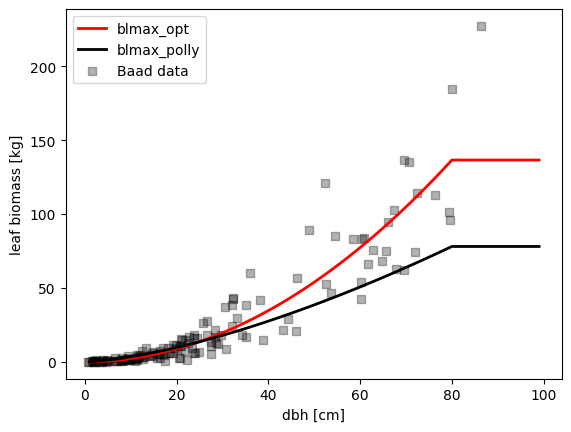

In [288]:

blmax_opt = d2blmax_salda(ds = diams,
                            p1 = fates_allom_d2bl1[2],
                            p2 = fates_allom_d2bl2[2],
                            p3 = fates_allom_d2bl3[2],
                            wood_density = 0.446,
                            dbh_maxh = 80)
plt.plot(diams, blmax_opt, label = "blmax_opt",color = "red", lw = 2)


#Polly
blmax_polly = d2blmax_salda(ds = diams,
                            p1 = pollys_params[0]["fates_allom_d2bl1"],
                            p2 = pollys_params[0]["fates_allom_d2bl2"],
                            p3 = pollys_params[0]["fates_allom_d2bl3"],
                            wood_density = 0.446,
                            dbh_maxh = 80)
plt.plot(diams, blmax_polly, label = "blmax_polly",color = "black", lw = 2)



#Baad data
plt.scatter(baad_pipo_leafbio.dbh_cm, baad_pipo_leafbio['m.lf'], label = "Baad data",color = "black", marker = "s", alpha = 0.3)

plt.xlabel('dbh [cm]')
plt.ylabel('leaf biomass [kg]')
plt.legend()
plt.show()

In [275]:
add_param_to_allometry_dict("fates_allom_d2bl1",fates_allom_d2bl1)
add_param_to_allometry_dict("fates_allom_d2bl2",fates_allom_d2bl2)
add_param_to_allometry_dict("fates_allom_d2bl3",fates_allom_d2bl3)

In [256]:
fates_allom_d2bl2

array([1.85679635, 2.0952578 , 1.97602707])

## Evaluate Polly's dbh to crown area allometry for Pine

Not too bad. Seems to overestimate the crown area of the young trees slightly and underestimate the crown area of the older trees

In [276]:
diams = list(range(1,100))

#### Use Baad to find optimal params for the base and exponent of the crown area function

In [277]:
baad_pipo_ca = prep_data_for_curve_fit(baad_df,"Pinus ponderosa","dbh_cm","a.cp")

popt, pcov = curve_fit(lambda d, p1, p2: carea_2pwr(d, p1, p2),
                       xdata=list(baad_pipo_ca['dbh_cm']), ydata=list(baad_pipo_ca['a.cp']))

# This parameter is the base of the 2 parameter power function.
# In the FATES code it is called the 'spread term'
# The spread term is actually a dynamic variable based on the
# site-level stand density and two parameters (fates_allom_d2ca_coefficient_max and
# fates_allom_d2ca_coefficient_in) that determine the amount
# of elasticity the crowns should have to respond to the stand density.
# Caution: fates_allom_d2ca_coefficient_(min/max) both affect the ultimate
# crown area

d2ca_base = getMeanMinMaxofParam(param = 0)
d2ca_expo = getMeanMinMaxofParam(param = 1)

# Use variation in the estimate of the base parameter for fates_allom_d2ca_coefficient_(min/max)
fates_allom_d2ca_coefficient_min = [d2ca_base[0] * 0.85, d2ca_base[0] * 1.15, d2ca_base[0]]
fates_allom_d2ca_coefficient_max = [d2ca_base[1] * 0.85, d2ca_base[1] * 1.15, d2ca_base[1]]




print("fates_allom_d2ca_coefficient_min",fates_allom_d2ca_coefficient_min)

print("fates_allom_d2ca_coefficient_mean,",d2ca_base[2])


print("fates_allom_d2ca_coefficient_max",fates_allom_d2ca_coefficient_max)
print("d2ca_base", d2ca_base)
print("d2ca_expo:",d2ca_expo)

# The exponent in FATES is calculated by adding and "exponent diff param" to fates_allom_d2bl2
fates_allom_blca_expnt_diff = d2ca_expo - pollys_params[0]['fates_allom_d2bl2']
#fates_allom_blca_expnt_diff = d2ca_expo - fates_allom_d2bl2[2]
print("fates_allom_blca_expnt_diff",fates_allom_blca_expnt_diff)



# How FATES actually calculates crown area
#plt.plot(basal_diams, crown_area_model, label = "PIPO_true_base", color = "black", lw = 2)
#plt.plot(basal_diams, ca_fates, label = "montane_shrub_fates", color = "green", lw =2)
#plt.legend()

fates_allom_d2ca_coefficient_min [0.024547552784774662, 0.033211394944106895, 0.02887947386444078]
fates_allom_d2ca_coefficient_mean, 0.05587588511263701
fates_allom_d2ca_coefficient_max [0.07044145190670825, 0.09530314081495822, 0.08287229636083324]
d2ca_base [0.02887947 0.0828723  0.05587589]
d2ca_expo: [1.49537907 1.73069078 1.61303492]
fates_allom_blca_expnt_diff [-0.00462093  0.23069078  0.11303492]


#### [Gill et al., 2000 model](https://www.sciencedirect.com/science/article/pii/S0378112799001139?via%3Dihub#aep-section-id11)



In [278]:
def Gill_2000(ds,b0,b1):
    
    r = []
    ca = []
    
    for d in ds:
        radius_tmp = b0 + b1 * d
        r.append(radius_tmp)
        ca_tmp = math.pi * radius_tmp **2
        ca.append(ca_tmp)
    return r,ca

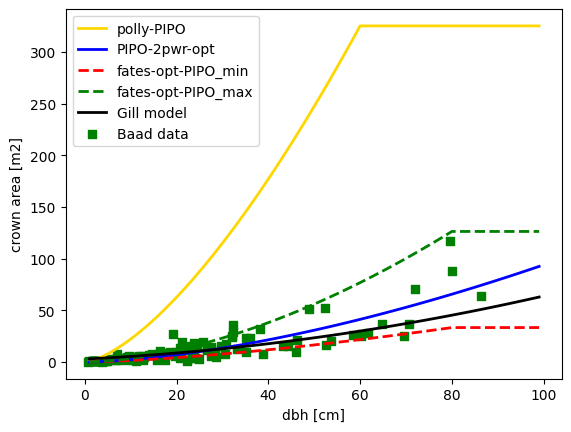

In [279]:
#Polly's params
ca,cd = d_to_crown_area_fates(ds=diams,
                                         d2bl_p2=pollys_params[0]['fates_allom_d2bl2'],
                                         d2bl_ediff=pollys_params[0]["fates_allom_blca_expnt_diff"],
                                         d2ca_max=pollys_params[0]["fates_allom_d2ca_coefficient_max"],
                                         d2ca_min=pollys_params[0]["fates_allom_d2ca_coefficient_min"],
                                         spread=0.5,dbh_maxh=60)

plt.plot(diams, ca, label = "polly-PIPO",color = pft_colors[0], lw = 2)

#Optimized 2 param pwr function
# Simple crown area model with fitted base and exponent 
crown_area_model = carea_2pwr(diams, d2ca_base[2], d2ca_expo[2])
plt.plot(diams, crown_area_model,label = "PIPO-2pwr-opt",color = "blue", lw = 2)


# Optimized new fates params
ca,cd = d_to_crown_area_fates(ds=diams,
                                         d2bl_p2=pollys_params[0]['fates_allom_d2bl2'],
                                         d2bl_ediff=fates_allom_blca_expnt_diff[0],
                                         d2ca_max=fates_allom_d2ca_coefficient_max[0],
                                         d2ca_min=fates_allom_d2ca_coefficient_min[0],
                                         spread=0.5, dbh_maxh=80)

plt.plot(diams, ca, label = "fates-opt-PIPO_min",color = "red", lw = 2, linestyle = "--")


# Optimized new fates params
ca,cd = d_to_crown_area_fates(ds=diams,
                                         d2bl_p2=pollys_params[0]['fates_allom_d2bl2'],
                                         d2bl_ediff=fates_allom_blca_expnt_diff[1],
                                         d2ca_max=fates_allom_d2ca_coefficient_max[1],
                                         d2ca_min=fates_allom_d2ca_coefficient_min[1],
                                         spread=0.5, dbh_maxh=80)


plt.plot(diams, ca, label = "fates-opt-PIPO_max",color = "green", lw = 2, linestyle = "--")

#Gill et al., 2000
r,ca_gill = Gill_2000(diams,b0=0.9488,b1=0.0356)
plt.plot(diams, ca_gill, label = "Gill model",color = "black", lw = 2)


#Baad data
plt.scatter(baad_pipo_ca['dbh_cm'], baad_pipo_ca['a.cp'], label = "Baad data",color = "green", marker = "s")

plt.xlabel('dbh [cm]')
plt.ylabel('crown area [m2]')
plt.legend()
plt.show()

## Check PIPO leaf biomass allometry

Underestimates leaf biomass of large trees

In [147]:
baad_pipo_leafbio = prep_data_for_curve_fit(baad_df,"Pinus ponderosa","dbh_cm","m.lf")

### Find optimal params for leaf biomass allometry

In [162]:
popt, pcov = curve_fit(lambda d, p1, p2, p3: d2blmax_salda(d, p1, p2, p3, wood_density= 0.446, dbh_maxh=80),
                       xdata=list(baad_pipo_leafbio['dbh_cm']), ydata=list(baad_pipo_leafbio['m.lf']))

# This parameter is the base of the 2 parameter power function.
# In the FATES code it is called the 'spread term'
# The spread term is actually a dynamic variable based on the
# site-level stand density and two parameters (fates_allom_d2ca_coefficient_max and
# fates_allom_d2ca_coefficient_in) that determine the amount
# of elasticity the crowns should have to respond to the stand density.
# Caution: fates_allom_d2ca_coefficient_(min/max) both affect the ultimate
# crown area

fates_allom_d2bl1 = getMeanMinMaxofParam(param = 0)
fates_allom_d2bl2 = getMeanMinMaxofParam(param = 1)
fates_allom_d2bl3 = getMeanMinMaxofParam(param = 2)

### Evaluate leaf biomass allometry

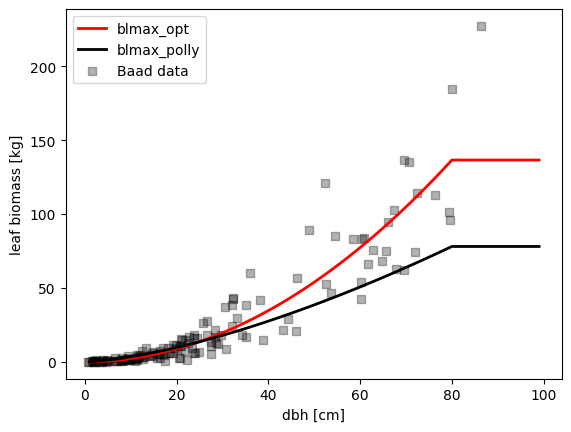

In [239]:

blmax_opt = d2blmax_salda(ds = diams,
                            p1 = fates_allom_d2bl1[2],
                            p2 = fates_allom_d2bl2[2],
                            p3 = fates_allom_d2bl3[2],
                            wood_density = 0.446,
                            dbh_maxh = 80)
plt.plot(diams, blmax_opt, label = "blmax_opt",color = "red", lw = 2)


#Polly
blmax_polly = d2blmax_salda(ds = diams,
                            p1 = pollys_params[0]["fates_allom_d2bl1"],
                            p2 = pollys_params[0]["fates_allom_d2bl2"],
                            p3 = pollys_params[0]["fates_allom_d2bl3"],
                            wood_density = 0.446,
                            dbh_maxh = 80)
plt.plot(diams, blmax_polly, label = "blmax_polly",color = "black", lw = 2)



#Baad data
plt.scatter(baad_pipo_leafbio.dbh_cm, baad_pipo_leafbio['m.lf'], label = "Baad data",color = "black", marker = "s", alpha = 0.3)

plt.xlabel('dbh [cm]')
plt.ylabel('leaf biomass [kg]')
plt.legend()
plt.show()

In [280]:
add_param_to_allometry_dict("fates_allom_d2ca_coefficient_min",fates_allom_d2ca_coefficient_min)
add_param_to_allometry_dict("fates_allom_d2ca_coefficient_max",fates_allom_d2ca_coefficient_max)
add_param_to_allometry_dict("fates_allom_blca_expnt_diff",fates_allom_blca_expnt_diff)

-0.004620930411389335

## Check PIPO diameter to height

In [281]:
baad_pipo_height = prep_data_for_curve_fit(baad_df,"Pinus ponderosa","dbh_cm","h.t")

### Find optimal height params

In [282]:
popt, pcov = curve_fit(lambda d, p1, p2: d2h_obrien(d, p1, p2, dbh_maxh=80),
                       xdata=list(baad_pipo_height['dbh_cm']), ydata=list(baad_pipo_height['h.t']))

# This parameter is the base of the 2 parameter power function.
# In the FATES code it is called the 'spread term'
# The spread term is actually a dynamic variable based on the
# site-level stand density and two parameters (fates_allom_d2ca_coefficient_max and
# fates_allom_d2ca_coefficient_in) that determine the amount
# of elasticity the crowns should have to respond to the stand density.
# Caution: fates_allom_d2ca_coefficient_(min/max) both affect the ultimate
# crown area

fates_allom_d2h1 = getMeanMinMaxofParam(param = 0)
fates_allom_d2h2 = getMeanMinMaxofParam(param = 1)

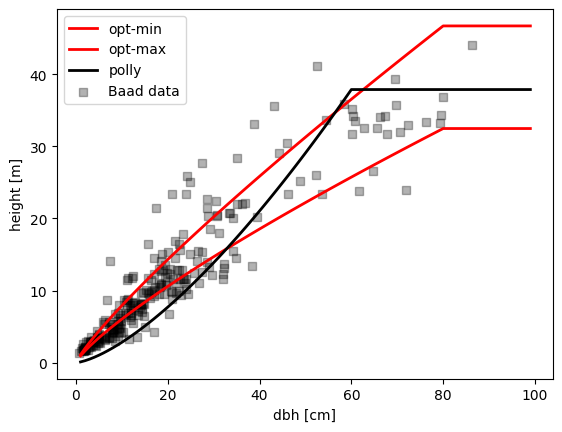

In [291]:
#optimal
#Polly's
h_opt = d2h_obrien(ds = diams,
                            p1 = fates_allom_d2h1[0],
                            p2 = fates_allom_d2h2[0],
                            dbh_maxh = 80)

plt.plot(diams, h_opt, label = "opt-min",color = "red", lw = 2)


h_opt = d2h_obrien(ds = diams,
                            p1 = fates_allom_d2h1[1],
                            p2 = fates_allom_d2h2[1],
                            dbh_maxh = 80)

plt.plot(diams, h_opt, label = "opt-max",color = "red", lw = 2)


#Polly's
h_polly = d2h_obrien(ds = diams,
                            p1 = pollys_params[0]["fates_allom_d2h1"],
                            p2 = pollys_params[0]["fates_allom_d2h2"],
                            dbh_maxh = 60)

plt.plot(diams, h_polly, label = "polly",color = "black", lw = 2)

#Baad data
plt.scatter(baad_pipo_height.dbh_cm, baad_pipo_height['h.t'], label = "Baad data",color = "black", marker = "s", alpha = 0.3)

plt.xlabel('dbh [cm]')
plt.ylabel('height [m]')
plt.legend()
plt.show()

In [284]:
add_param_to_allometry_dict("fates_allom_d2h1",fates_allom_d2h1)
add_param_to_allometry_dict("fates_allom_d2h2",fates_allom_d2h2)

,fates_name,min_value,max_value,mean
0,fates_allom_d2bl1,-9.376309e+05,9.376313e+05,0.229223
1,fates_allom_d2bl2,1.856796e+00,2.095258e+00,1.976027
2,fates_allom_d2bl3,-5.072121e+06,5.072127e+06,2.810485
3,fates_allom_d2ca_coefficient_min,2.454755e-02,3.321139e-02,0.028879
4,fates_allom_d2ca_coefficient_max,7.044145e-02,9.530314e-02,0.082872
5,fates_allom_blca_expnt_diff,-4.620930e-03,2.306908e-01,0.113035
6,fates_allom_d2h1,8.089915e-01,8.537199e-01,0.831356
7,fates_allom_d2h2,-2.815632e-02,4.455624e-02,0.008200


## Check PIPO diameter to AGWB

Here we use the models from Chojnacky et al., 2014 to evaluate Polly's parameters for AGWB

In [235]:
def Chojnacky_d2_AGB(ds,b0,b1):
    '''input: diameters [cm],
    output: AGB [kg]'''
    
    agb = []
    for i,d in enumerate(ds):
        
        log_agb = b0 + b1 * np.log(d)
        agbh_temp = np.exp(log_agb)
        agb.append(agbh_temp)
    return agb

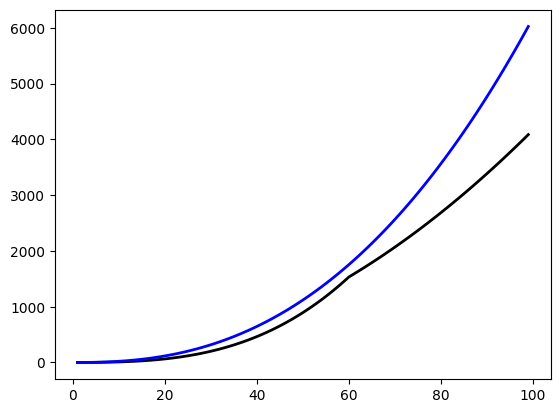

In [236]:
agwb_polly = dh2bagw_salda(p1 = pollys_params[0]["fates_allom_agb1"],
              p2 = pollys_params[0]["fates_allom_agb2"],
              p3 = pollys_params[0]["fates_allom_agb3"],
              p4 = pollys_params[0]["fates_allom_agb4"],
              allom_agb_frac=0.6,
              ds=diams,
              heights=h_polly,
              wood_density=0.446)

agb_polly = np.array(agwb_polly) + np.array(blmax_polly)
plt.plot(diams, agb_polly, label = "polly",color = "black", lw = 2)

agb_chojnacky = Chojnacky_d2_AGB(ds = diams,b0 = -2.6177,b1 = 2.4638)

plt.plot(diams, agb_chojnacky, label = "chojnacky",color = "blue", lw = 2)

## Write out file

In [293]:
allometry_range_df = pd.DataFrame.from_dict(allometry_dict)

if write_to_csv == True:

    now = datetime.now()
    dt_string = now.strftime("%m-%d-%Y-%H-%M-%S")
    file_path = "pine_param_ranges_data_derived_" + dt_string + ".csv"
    allometry_range_df.to_csv(file_path, index=False)